v.d.11: Classificação se é fato gerador ou não e da categoria (SE, CI, CA) de uma só fez (4 categorias: NÃO, SE, CI, CA) e em 2 etapas, utilizando TF-IDF e Decision Tree, sem e com limpeza de dados, balanceamento, otimização de hiperparâmetros com Optuna.

In [ ]:
!pip install optuna

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados

In [ ]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import joblib

# Importa bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix, mean_squared_error
from collections import Counter
import optuna
from optuna.samplers import TPESampler

# Configurações
pd.set_option('display.max_colwidth', None)
optuna.logging.set_verbosity(optuna.logging.WARNING) # Desativa log de saída

In [ ]:
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')
df_completo.head()

,descricao,fato_gerador,categoria,descricao_limpa,descricao_lematizada
0,Pagamento Referente Aos Serviços De Transporte De Técnicos Durante Supervisão Escolar Nas Escolas Da Zona Rural Deste Município. Referente Ao Mês De Agosto De 2020.,Sim,CA,transporte técnicos supervisão escolar escolas deste,transporte técnico supervisão escolar escola de este
1,"Pagamento Referente Aos Serviços De Transporte De Técnicos Da Secretaria De Educação, Durante Supervisão Escolar Em Unidades Escolares Da Rede Municipal De Ensino. Referente Ao Mês De Maio De 2020.",Sim,CA,transporte técnicos educação supervisão escolar unidades escolares rede,transporte técnico Educação supervisão escolar unidade escolar rede
2,Serviços De Transporte De Infraestrutura Deste Municipio.,Sim,CA,transporte infraestrutura deste municipio,transporte infraestrutura de este municipio
3,Pagamento Referente Aos Serviços De Transporte De Materiais De Expediente Para Atender As Escolas Da Rede Municipal De Ensino.,Sim,CA,transporte materiais expediente escolas rede,transporte material expediente escola rede
4,Serviços De Transportes De Materiais Para Serviços De Infraestrutura Urbana Para Atender As Necessidades As Necessidades Município.,Sim,CA,transportes materiais infraestrutura urbana necessidades necessidades,transporte material infraestrutura urbano necessidade necessidades


In [ ]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
df.head()

,descricao_lematizada,fato_gerador,categoria
0,transporte técnico supervisão escolar escola de este,Sim,CA
1,transporte técnico Educação supervisão escolar unidade escolar rede,Sim,CA
2,transporte infraestrutura de este municipio,Sim,CA
3,transporte material expediente escola rede,Sim,CA
4,transporte material infraestrutura urbano necessidade necessidades,Sim,CA


In [ ]:
df['fato_gerador'].value_counts()

,count
fato_gerador,
Sim,30834
Não,7873


In [ ]:
df['categoria'].value_counts()

,count
categoria,
CI,28259
Não,7873
CA,2090
SE,485


## 2. Classificação em 1 etapa (fato gerador e categoria simultaneamente)

### 2.1. Otimização de hiper parâmetros

In [ ]:
import matplotlib.pyplot as plt
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)

# Separação entre variáveis preditoras e alvo e divisão em treino e teste
X = df_sample['descricao_lematizada']
y = df_sample['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define o pipeline incluindo o extrator de features do texto e um classificador
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf',  DecisionTreeClassifier())
])


In [ ]:
# Otimização dos hiperparâmetros do DecisionTreeClassifier com Optuna

# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Função objetivo de otimização
def objective(trial):
    params = {
        #"objective": "multi:softmax",
        #"num_class": 4,
        #"verbosity": 0,
        #"ccp_alpha": trial.suggest_float("ccp_alpha", 1e-3, 1),
        "random_state": 42,
        "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 1e-3, 1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 28, step=2),
        "max_depth": trial.suggest_int("max_depth", 5, 30, step=5),
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Resultado
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor Precision-Score:', study.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Melhores hiperparâmetros: {'min_impurity_decrease': 0.0017113920900264177, 'min_samples_leaf': 8, 'max_depth': 30}
Melhor Precision-Score: 0.9805685989202285


In [ ]:
# Pipeline com TF-IDF, balanceamento de classe e melhor modelo do DecisionTreeClassifier
# Redução do desbalanceamento das classes

# Pipeline
best_model = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(**study.best_params))
])

### 2.2. Análise das predições do modelo

In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

F1-Score balanceado: 0.9836105167158025
              precision    recall  f1-score   support

          CA       0.97      0.91      0.94       627
          CI       0.98      0.99      0.99      8478
         Não       0.99      0.98      0.98      2362
          SE       0.87      0.86      0.87       146

    accuracy                           0.98     11613
   macro avg       0.96      0.93      0.94     11613
weighted avg       0.98      0.98      0.98     11613



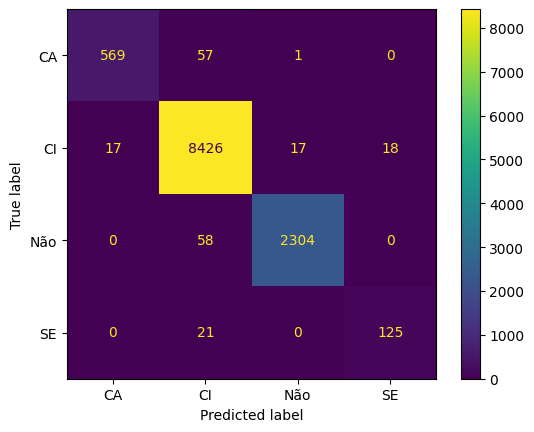

In [ ]:
# Ajuste do modelo e predição
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 2.3 Análise das predições do modelo

In [ ]:
prob_pred = best_model.predict_proba(X_test)

In [ ]:

# Dataframe para conferência das previsões e respectivas probabilidades
df_check = pd.DataFrame(X_test)
df_check['target'] = y_test
df_check['prediction'] = y_pred
df_check['prob_CA'] = np.round(prob_pred[0:,0],6).tolist()
df_check['prob_CI'] = np.round(prob_pred[0:,1],6).tolist()
df_check['prob_Não'] = np.round(prob_pred[0:,2],6).tolist()
df_check['prob_SE'] = np.round(prob_pred[0:,3],6).tolist()
df_check.head()

,descricao_lematizada,target,prediction,prob_CA,prob_CI,prob_Não,prob_SE
14303,professor nível alto hora aulo trabalhar área pedagogia emef jaituba relativo,CI,CI,0.003629,0.987349,0.006585,0.002437
25730,assessoriar consultoria jurídico,CI,CI,0.003629,0.987349,0.006585,0.002437
31502,aluguel embarcacao utilizar transporte escolar f sao Jorge Rio,Não,Não,0.000414,0.000000,0.999586,0.000000
16132,técnico enfermagem posto saúde chiquinho nabiçar,CI,CI,0.003629,0.987349,0.006585,0.002437
35225,aluguel embarcacao utilizar transporte escolar f santo helena rio,Não,Não,0.000414,0.000000,0.999586,0.000000


In [ ]:
# Listar as previsões erradas
df_check[df_check['target'] != df_check['prediction']]

,descricao_lematizada,target,prediction,prob_CA,prob_CI,prob_Não,prob_SE
1218,motorista veiculo pesado lotar saber marco,CA,CI,0.003629,0.987349,0.006585,0.002437
31073,auxilio financeiro cobrir despesa compra medicamento,Não,CI,0.003629,0.987349,0.006585,0.002437
7820,digitador setor contábil,CI,SE,0.000000,0.436170,0.000000,0.563830
6367,ser frete voadeira transportar técnico pedagógico visitar escola fundamental localidade Santa Maria andirobal rua fogo joana per umarizal araquembaua baixinho,CI,CA,0.993289,0.006711,0.000000,0.000000
32130,carro alugar educação de este,Não,CI,0.003629,0.987349,0.006585,0.002437
...,...,...,...,...,...,...,...
20410,ser mecânico manutenção maquino pesar sec exec infraestrutura de este,CI,CA,0.953846,0.046154,0.000000,0.000000
1250,operador maquino nivelador obra transporte,CA,CI,0.108392,0.884615,0.006993,0.000000
1321,transporte tubo concreto obra,CA,CI,0.108392,0.884615,0.006993,0.000000
31954,ajudar custo combater covid,Não,CI,0.003629,0.987349,0.006585,0.002437


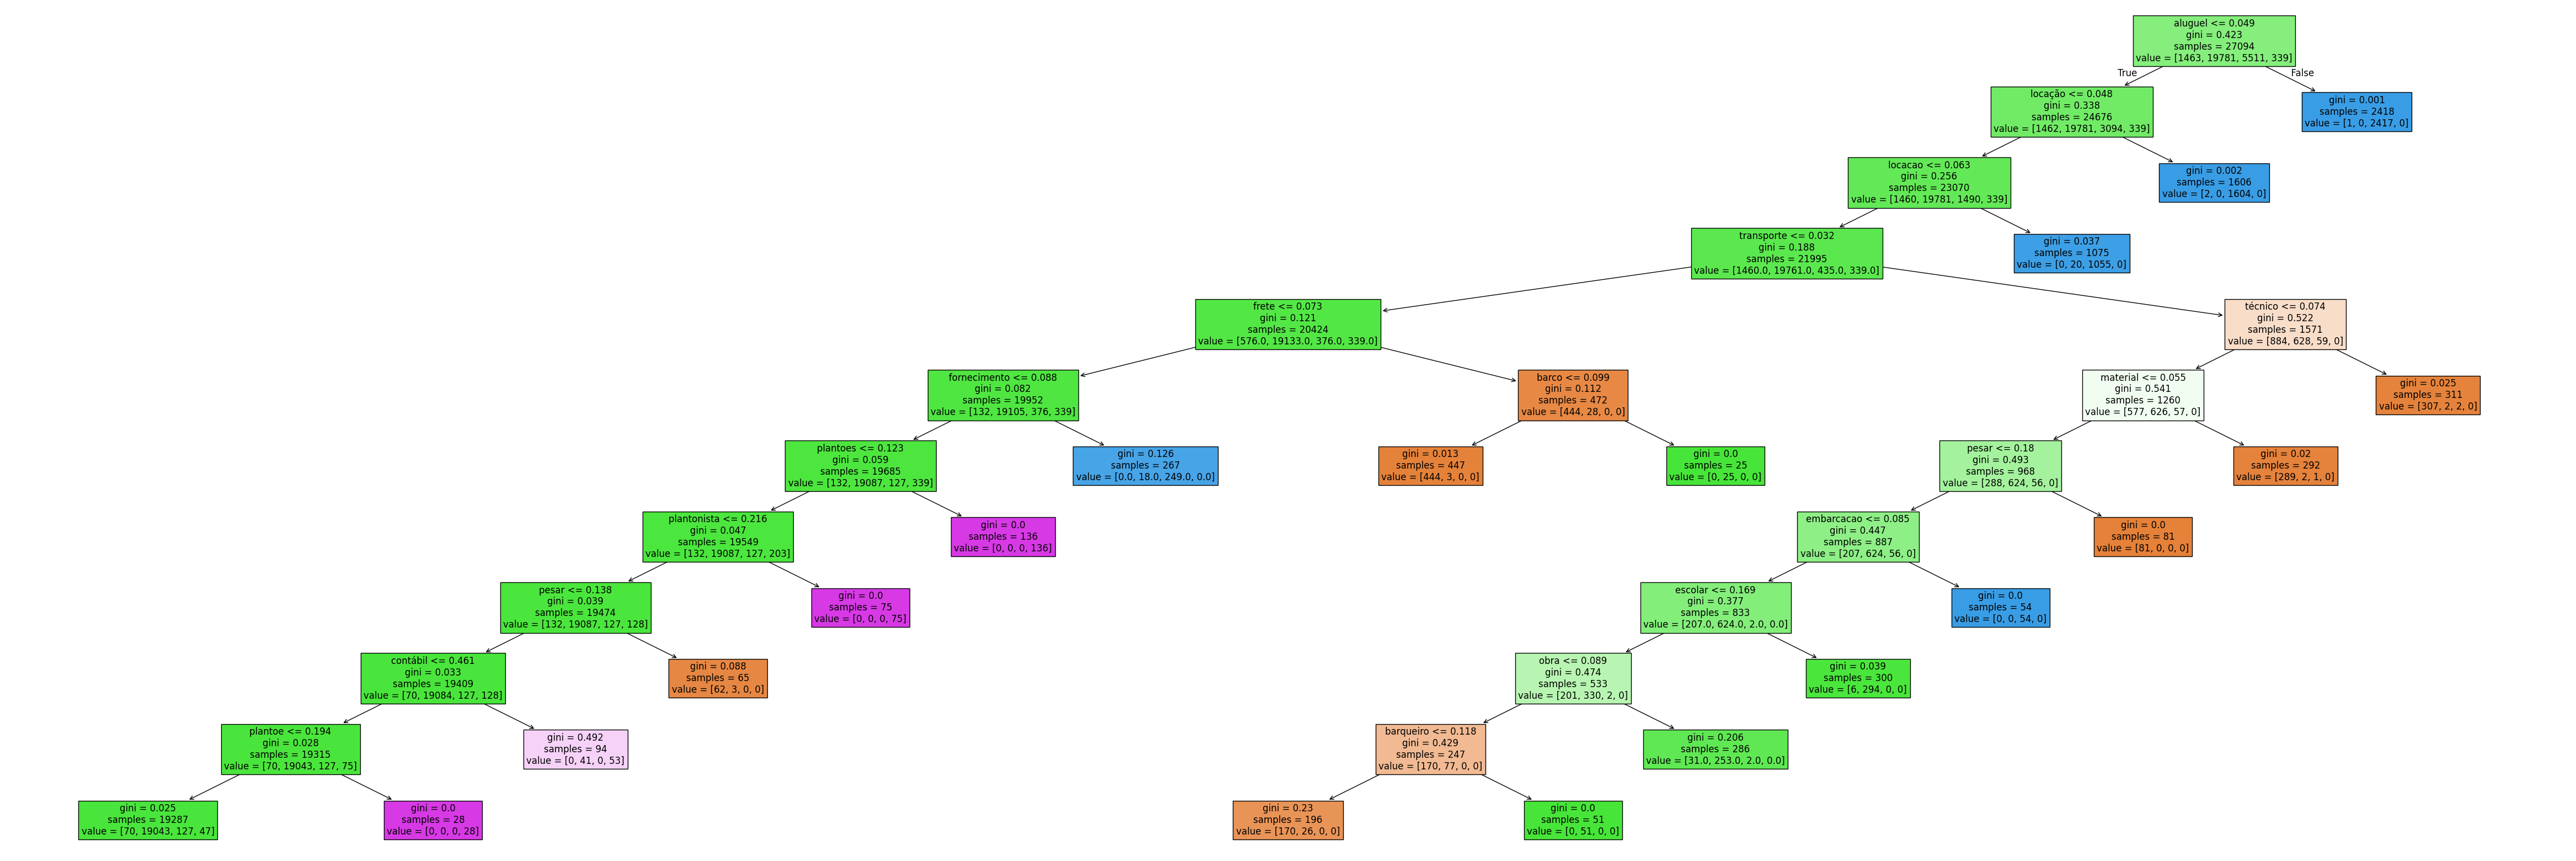

In [ ]:
# Imprimindo a árvore de decisão
tfidf_features = best_model.named_steps['tfidf'].get_feature_names_out()
plt.figure(figsize=(60,20))
# Access the DecisionTreeClassifier within the pipeline using named_steps
plot_tree(best_model.named_steps['classifier'], feature_names=tfidf_features, filled=True, fontsize=12)
plt.show()

In [ ]:
# salvar o modelos best_model

joblib.dump(best_model, '/content/drive/MyDrive/projeto classificacao de lancamento/modelos/dectree_best_model.pkl')

['/content/drive/MyDrive/projeto classificacao de lancamento/modelos/dectree_best_model.pkl']

In [ ]:
# Cross-validation
#cv_score = cross_val_score(pipeline, X_train, y_train, cv=5)
#print('Score per fold:', cv_score)
#print('Média =', cv_score.mean())
#print('Desvio padrão =', cv_score.std())

In [ ]:
#pipeline.score(X_test, y_test)

In [ ]:
'''
# prompt: Imprima a profundidade do classificador arvore
tree_depth = best_model.named_steps['clf'].get_depth()
print("Profundidade da árvore:", tree_depth)
tree_features = best_model.named_steps['clf'].tree_.feature
tfidf_features = best_model.named_steps['tfidf'].get_feature_names_out()
print(tree_features.shape)
print(tfidf_features)
'''

'\n# prompt: Imprima a profundidade do classificador arvore\ntree_depth = best_model.named_steps[\'clf\'].get_depth()\nprint("Profundidade da árvore:", tree_depth)\ntree_features = best_model.named_steps[\'clf\'].tree_.feature\ntfidf_features = best_model.named_steps[\'tfidf\'].get_feature_names_out()\nprint(tree_features.shape)\nprint(tfidf_features)\n'

## 3. Classificação em 2 etapas (primeiro fato gerador, depois categoria)

In [ ]:
print('Formato:', df.shape)
df.head()

Formato: (38707, 3)


,descricao_lematizada,fato_gerador,categoria
0,transporte técnico supervisão escolar escola de este,Sim,CA
1,transporte técnico Educação supervisão escolar unidade escolar rede,Sim,CA
2,transporte infraestrutura de este municipio,Sim,CA
3,transporte material expediente escola rede,Sim,CA
4,transporte material infraestrutura urbano necessidade necessidades,Sim,CA


### 3.1. Classificação de fato gerador

In [ ]:
%%time
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']

# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Função objetivo de otimização
def objective(trial):
    params = {
        #"objective": "multi:softmax",
        #"num_class": 4,
        #"verbosity": 0,
        "random_state": 42,
        "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 1e-3, 1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 28, step=2),
        "max_depth": trial.suggest_int("max_depth", 5, 30, step=5),
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Resultado
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor F1-Score:', study.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Melhores hiperparâmetros: {'min_impurity_decrease': 0.0017113920900264177, 'min_samples_leaf': 8, 'max_depth': 30}
Melhor F1-Score: 0.9941441471557481
CPU times: user 6.42 s, sys: 66.7 ms, total: 6.49 s
Wall time: 13 s


In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['fato_gerador']
X_test, y_test = df_test['descricao_lematizada'], df_test['fato_gerador']

F1-Score balanceado: 0.99343578177135
              precision    recall  f1-score   support

         Não       0.99      0.98      0.98      2362
         Sim       0.99      1.00      1.00      9251

    accuracy                           0.99     11613
   macro avg       0.99      0.99      0.99     11613
weighted avg       0.99      0.99      0.99     11613



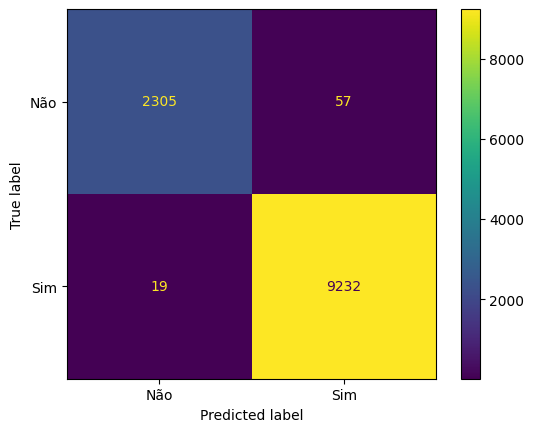

In [ ]:
# Pipeline
best_model_1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(**study.best_params))
])

# Ajuste do modelo e predição
best_model_1.fit(X_train, y_train)
y_pred = best_model_1.predict(X_test)
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 3.2. Classificação de categoria

In [ ]:
%%time
# Dataframe de teste para determinação das melhores técnicas de processamento de texto e melhores hyperparâmetros.
# O método sample estratifica o dataframe proporcionalmente às classes.
df_sample = df.sample(8000, random_state=42)
df_sample = df_sample[df_sample['fato_gerador'] == 'Sim']
df_train, df_test = train_test_split(df_sample, test_size=0.3, stratify=df_sample[['fato_gerador', 'categoria']], random_state=42)

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']


# Transformação TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,1))
tfidf.fit(X_train)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

# Função objetivo de otimização
def objective(trial):
    params = {
        #"objective": "multi:softmax",
        #"num_class": 4,
        #"verbosity": 0,
        "random_state": 42,
        "min_impurity_decrease" : trial.suggest_float("min_impurity_decrease", 1e-3, 1),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 4, 28, step=2),
        "max_depth": trial.suggest_int("max_depth", 5, 30, step=5),
    }

    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return f1

# Otimização
sampler = TPESampler(seed=10)  # Make the sampler behave in a deterministic way.
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Resultado
print('Melhores hiperparâmetros:', study.best_params)
print('Melhor F1-Score:', study.best_value)

  0%|          | 0/50 [00:00<?, ?it/s]

Melhores hiperparâmetros: {'min_impurity_decrease': 0.0029110607307843983, 'min_samples_leaf': 10, 'max_depth': 25}
Melhor F1-Score: 0.9785787212766368
CPU times: user 3.18 s, sys: 41.9 ms, total: 3.22 s
Wall time: 3.32 s


In [ ]:
# Recuperação do dataset completo, filtro das observações fato_gerador = 1
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)
df_train = df_train[df_train['fato_gerador'] == 'Sim']
df_test = df_test[df_test['fato_gerador'] == 'Sim']

# Divisão em treino e teste
X_train, y_train = df_train['descricao_lematizada'], df_train['categoria']
X_test, y_test = df_test['descricao_lematizada'], df_test['categoria']

F1-Score balanceado: 0.9804620958374507
              precision    recall  f1-score   support

          CA       0.87      0.93      0.90       627
          CI       0.99      0.99      0.99      8478
          SE       0.86      0.79      0.82       146

    accuracy                           0.98      9251
   macro avg       0.91      0.90      0.90      9251
weighted avg       0.98      0.98      0.98      9251



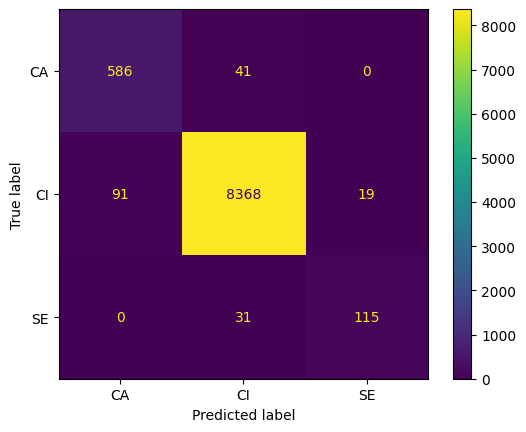

In [ ]:
# Ajuste do modelo e predição

# Pipeline
best_model_2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', DecisionTreeClassifier(**study.best_params))
])

best_model_2.fit(X_train, y_train)
y_pred = best_model_2.predict(X_test)
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### 3.3. Combinação dos classificadores de cada etapa
> O modelo best_model_1 faz a classificação de fato gerador.

> O modelo best_model_2 faz a classificação de categoria.

In [ ]:
# Recuperação do dataset completo e divisão em treino e teste
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df[['fato_gerador', 'categoria']], random_state=42)

In [ ]:
df_test['fg_pred'] = best_model_1.predict(df_test['descricao_lematizada'])

df_test_sim = df_test[df_test['fg_pred'] == 'Sim']
df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])

df_test_nao = df_test[df_test['fg_pred'] == 'Não']
df_test_nao['cat_pred'] = 'Não'

df_test = pd.concat([df_test_sim, df_test_nao], ignore_index=True)

<ipython-input-172-b2feaf844b1e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_sim['cat_pred'] = best_model_2.predict(df_test_sim['descricao_lematizada'])
<ipython-input-172-b2feaf844b1e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_nao['cat_pred'] = 'Não'


F1-Score balanceado: 0.9804620958374507
              precision    recall  f1-score   support

          CA       0.88      0.93      0.90       627
          CI       0.99      0.99      0.99      8478
         Não       0.99      0.98      0.98      2362
          SE       0.86      0.79      0.82       146

    accuracy                           0.98     11613
   macro avg       0.93      0.92      0.92     11613
weighted avg       0.98      0.98      0.98     11613



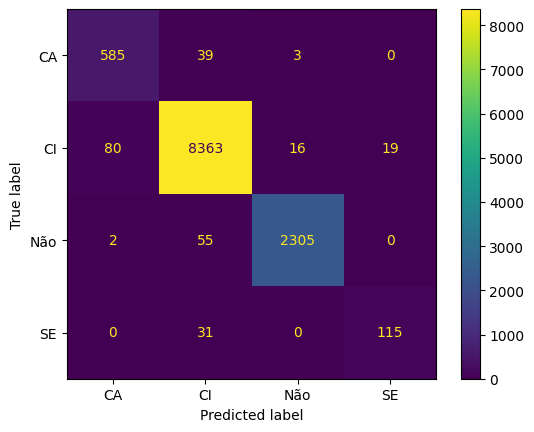

In [ ]:
# Métricas de avaliação da predição
print("F1-Score balanceado:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(df_test['categoria'], df_test['cat_pred']))
ConfusionMatrixDisplay.from_predictions(df_test['categoria'], df_test['cat_pred'])

In [ ]:
# Listar as previsões erradas
df_error = df_test[df_test['categoria'] != df_test['cat_pred']]
print('Quantidade de previsões erradas:', df_error.shape[0])
df_error

Quantidade de previsões erradas: 245


,descricao_lematizada,fato_gerador,categoria,fg_pred,cat_pred
12,digitador setor contábil relacionar rede,Sim,CI,Sim,SE
131,ser dez plantão emergencia hospital joaquim enfermeiro,Sim,SE,Sim,CI
138,servico prestar medico cirurgiaor hospital sete plantoe trabalhar,Sim,SE,Sim,CI
166,hospedagem secelt,Não,Não,Sim,CI
317,barqueiro transporte Kits alimentação Emefs ribeirinhar localidade descriminar recibo ano letivo,Sim,CI,Sim,CA
...,...,...,...,...,...
10802,ser locação levar trazer correspondencia saude baiao regional,Sim,CA,Não,Não
11285,ajudar custo custeio locacao imovel transporte alimentacao conforme portaria,Sim,CI,Não,Não
11437,fornecimento bufe gabinete,Sim,CI,Não,Não
11477,ajudar custo custeio locacao imovel transporte alimentacao conforme portaria,Sim,CI,Não,Não


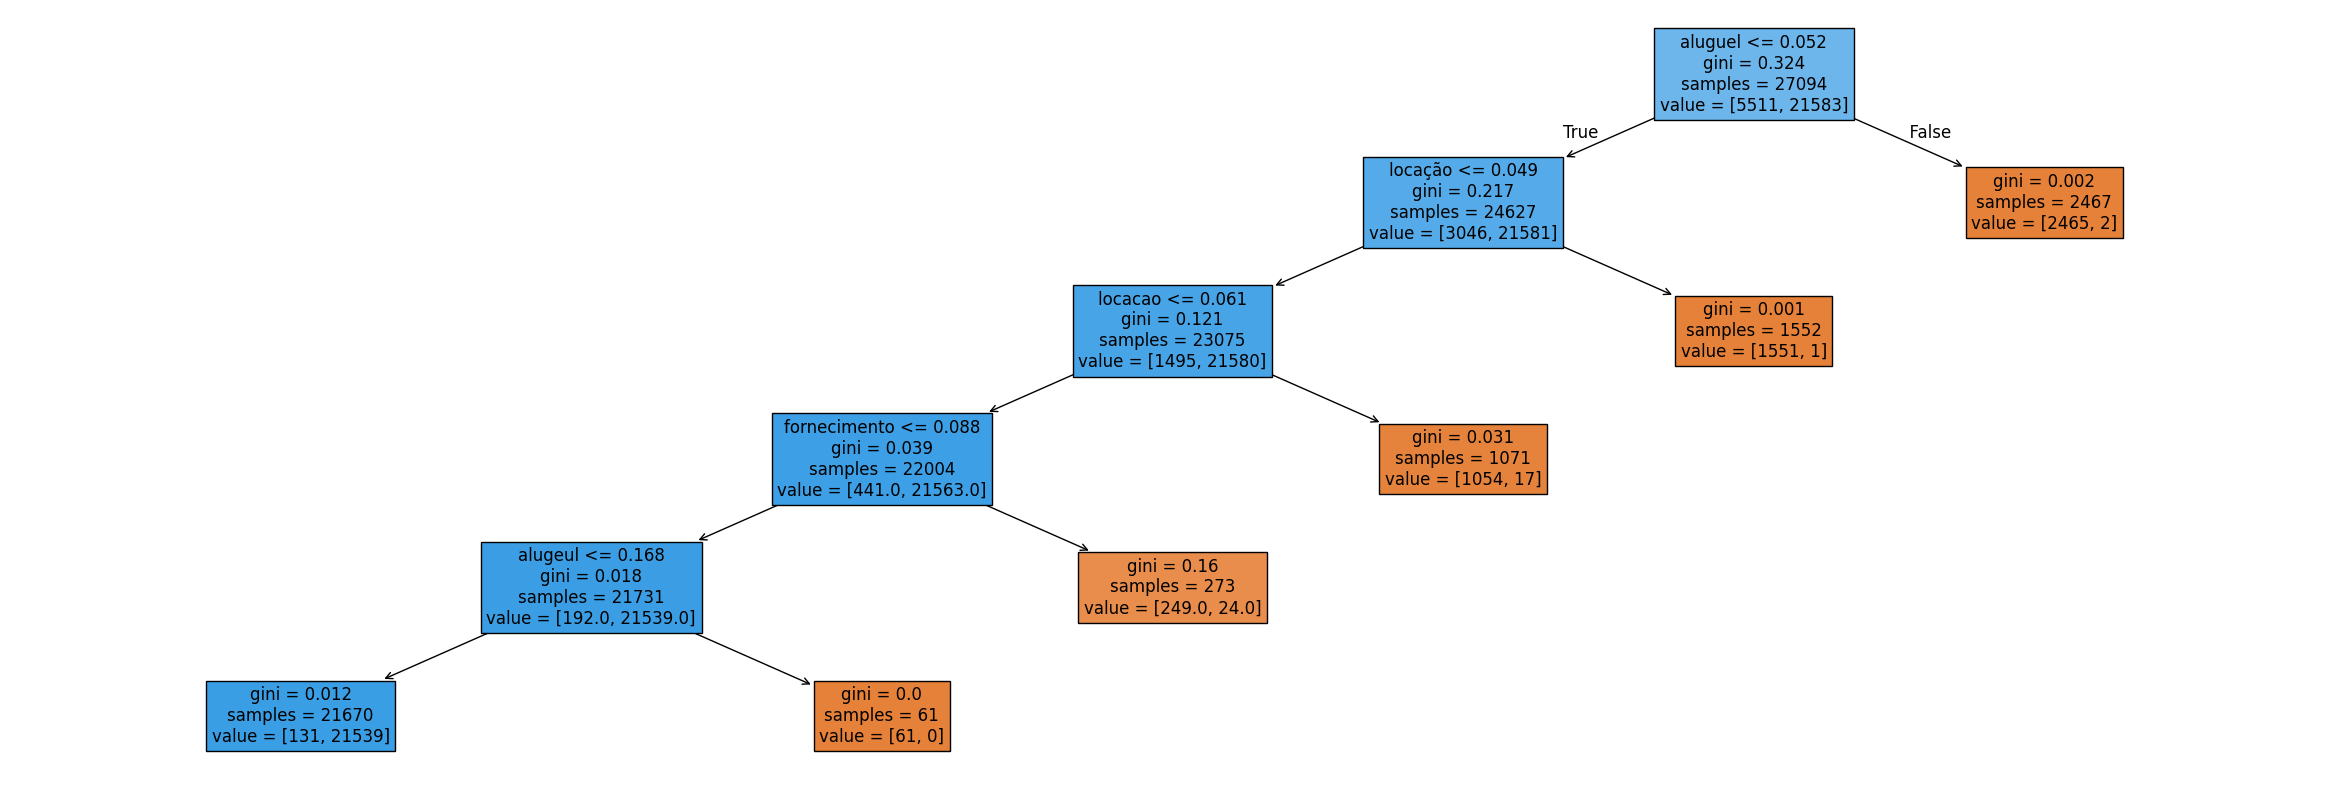

In [ ]:
# Imprimindo as árvores de decisão dos models best_model_1 e best_model_2
tfidf_features = best_model_1.named_steps['tfidf'].get_feature_names_out()
plt.figure(figsize=(30,10))
# Access the DecisionTreeClassifier within the pipeline using named_steps
plot_tree(best_model_1.named_steps['classifier'], feature_names=tfidf_features, filled=True, fontsize=12)
plt.show()

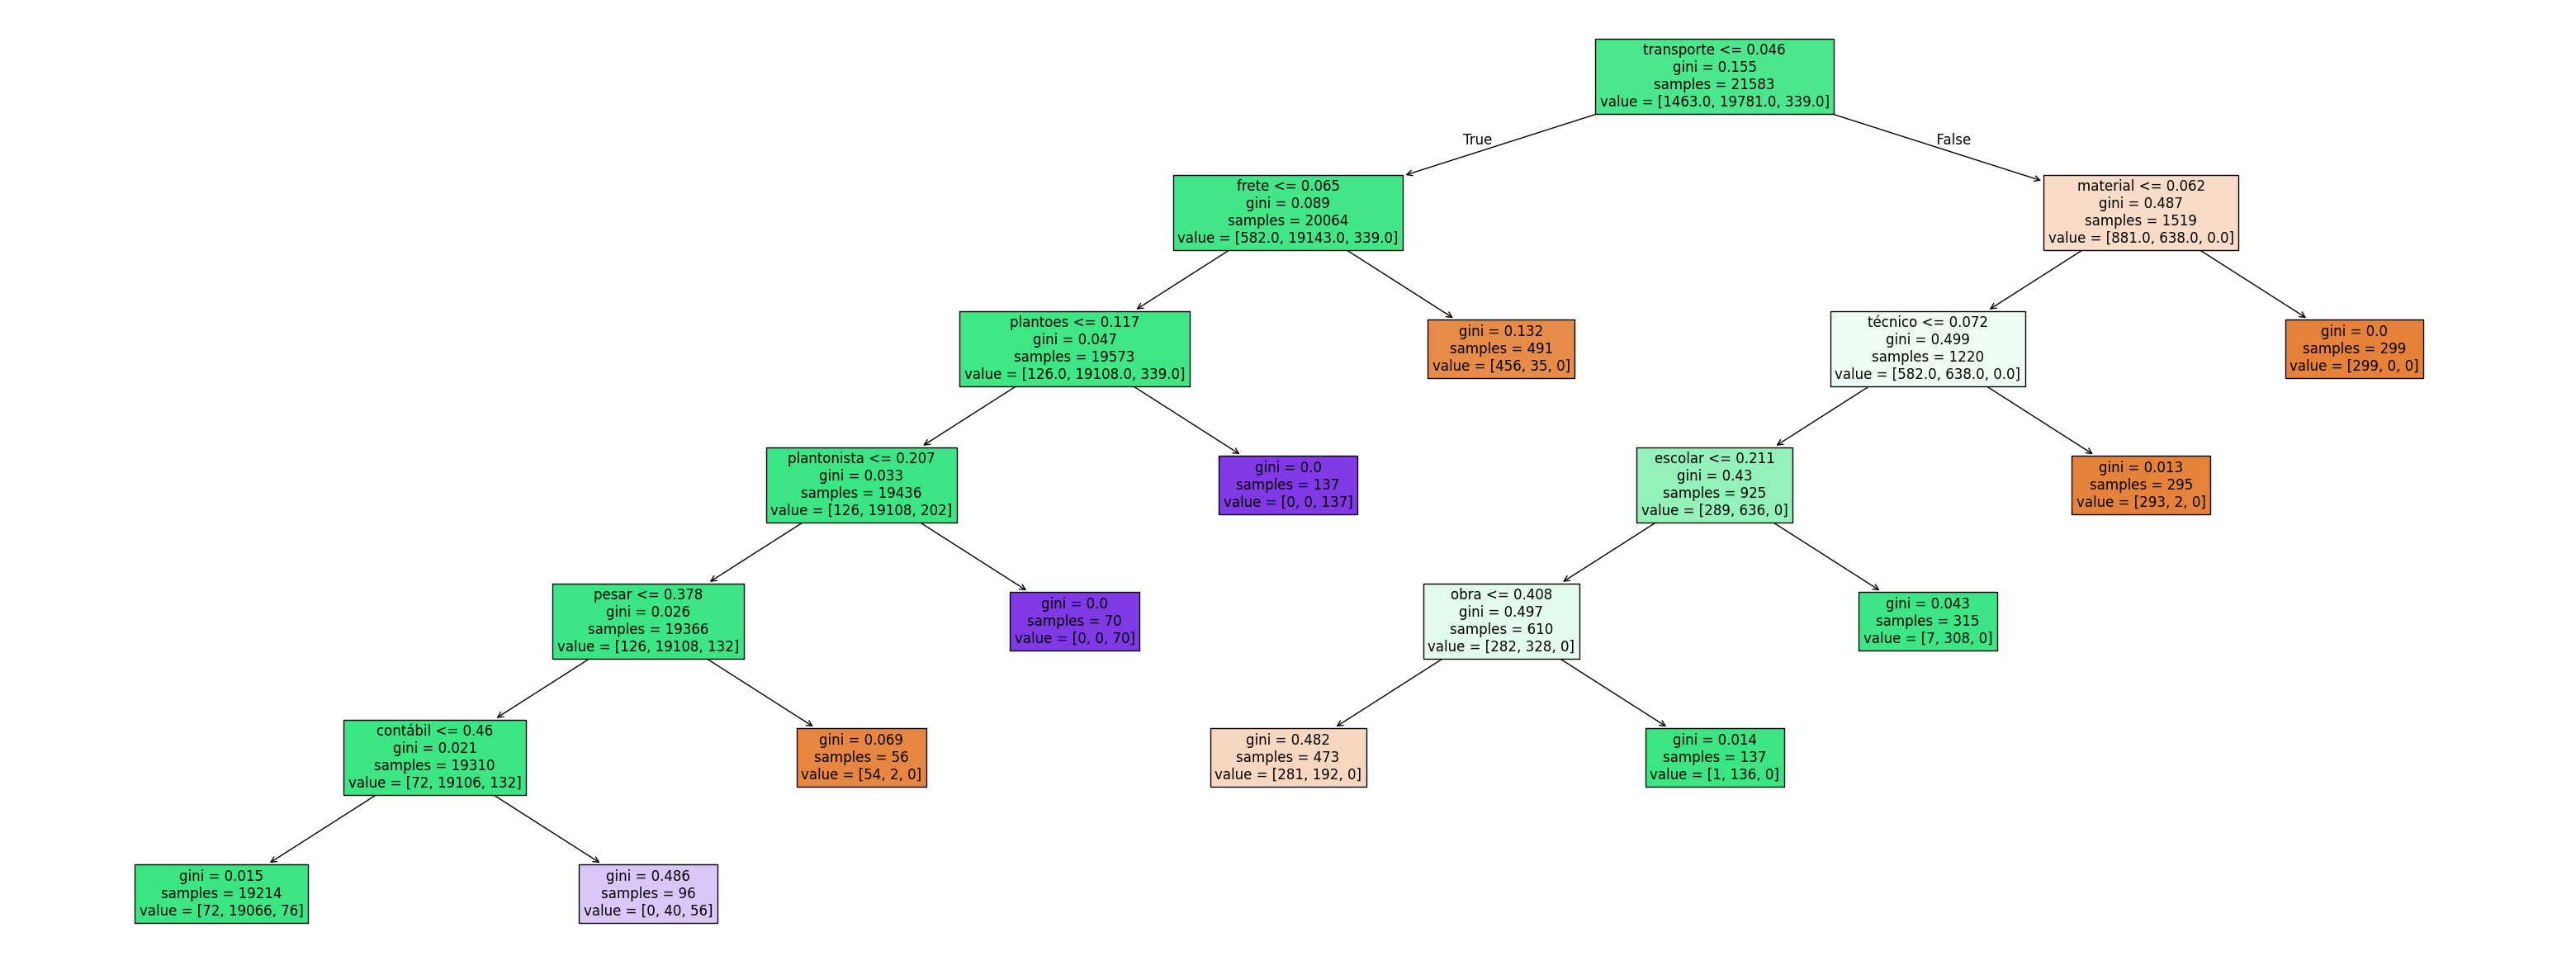

In [ ]:
tfidf_features = best_model_2.named_steps['tfidf'].get_feature_names_out()
plt.figure(figsize=(40,15))
# Access the DecisionTreeClassifier within the pipeline using named_steps
plot_tree(best_model_2.named_steps['classifier'], feature_names=tfidf_features, filled=True, fontsize=12)
plt.show()

In [ ]:
# prompt: # salvar os modelos best_model_1 e best_model_2

import joblib

# Replace 'best_model_1.pkl' and 'best_model_2.pkl' with your actual filenames
joblib.dump(best_model_1, '/content/drive/MyDrive/projeto classificacao de lancamento/modelos/dectree_best_model_1.pkl')
joblib.dump(best_model_2, '/content/drive/MyDrive/projeto classificacao de lancamento/modelos/dectree_best_model_2.pkl')

['/content/drive/MyDrive/projeto classificacao de lancamento/modelos/dectree_best_model_2.pkl']